In [1]:
import warnings; warnings.simplefilter('ignore')

import sys
sys.path.insert(0, '/home/jake/Data/Repos/')

import Utils as U
import gratings as gt

import NDN3.NDNutils as NDNutils

which_gpu = NDNutils.assign_gpu()

import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = str(0)

from scipy.ndimage import gaussian_filter
from copy import deepcopy

import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt  # plotting
import seaborn as sns

import NDN3.NDN as NDN
import NDN3.Utils.DanUtils as DU

output_dir = '/home/jcbyts/PyPlay/tensorboard' + str(which_gpu)
print(output_dir)

*******************************************************************************************
---> getting list of available GPUs:
[0, 1]

---> getting GPU memory map:
{0: 135, 1: 218}

---> setting up GPU with largest available memory:
   ...picking GPU # 0
*******************************************************************************************

Done!
/home/jcbyts/PyPlay/tensorboard0


In [2]:
import scipy.io as sio
import deepdish as dd
from copy import deepcopy

dirname = '/home/jcbyts/Data/MitchellV1FreeViewing/stim_movies/'

# flist = ['logan_20200304_Gabor_0__0_40_40_2_1_1_9.mat',
#         'logan_20200304_Grating_0__0_40_40_2_1_1_9.mat']

flist = ['logan_20200304_Gabor_-10__0_30_50_2_1_0_9_0.mat',
         'logan_20200304_Grating_-10__0_30_50_2_1_0_9_0.mat']
# try:
#     matdat = sio.io.load(dirname + fname)
# except AttributeError:
#     matdat = dd.io.load(dirname + fname)
    

In [93]:
from scipy.signal import convolve2d

def load_stim_files(dirname=None,flist=None,padd=50):
    import scipy.io as sio
    import deepdish as dd
    from copy import deepcopy
    
    Stim,Robs,valdat,labels,valid,NX,NY,dt,eyeAtFrame,frameTime = [],[],[],[],[],[],[],[],[],[]
    
    if type(flist)==str:
        flist = [flist]
    
    
    for fname in flist:

        try:
            matdat = sio.io.load(dirname + fname)
        except AttributeError:
            matdat = dd.io.load(dirname + fname)
            
        Stim.append(deepcopy(matdat['stim']).T)
        Robs.append(deepcopy(matdat['Robs']).T)
        valid = deepcopy(matdat['valdata']).T
        valid[matdat['blocks'][0,:].astype(int)-1] = 0 # create gaps in valid where blocks start (these will be split)
        valdat.append(valid) # offset by number of existing timesteps before this file
        labels.append(deepcopy(matdat['labels']).T)
        dt.append(deepcopy(matdat['dt']))
        NX.append(deepcopy(matdat['NX']))
        NP = Stim[-1].shape[1]
        NY.append(NP//NX[-1])
        NC = Robs[-1].shape[1]
        eyeAtFrame.append(deepcopy(matdat['eyeAtFrame']).T)
        frameTime.append(deepcopy(matdat['frameTimes']).T)
        
        stimspacer = np.zeros((padd,NP))
        Robsspacer = np.zeros((padd,NC))
        spacer = np.zeros((padd,1))
        espacer = np.zeros((padd,eyeAtFrame[-1].shape[1]))
        
        Stim.append(stimspacer)
        Robs.append(Robsspacer)
        valdat.append(spacer)
        labels.append(spacer)
        frameTime.append(spacer)
        eyeAtFrame.append(espacer)
        
         
    
    Stim = np.concatenate(Stim, axis=0)
    Robs = np.concatenate(Robs, axis=0)
    valdat = np.concatenate(valdat, axis=0)
    labels = np.concatenate(labels, axis=0)
    eyeAtFrame = np.concatenate(eyeAtFrame, axis=0)
    frameTime = np.concatenate(frameTime, axis=0)
    NX = np.mean(np.concatenate(NX)).astype(int)
    NY = np.mean(np.concatenate(NY)).astype(int)
    dt = np.mean(np.concatenate(dt))
    
    return Stim,Robs,valdat,labels,NX,NY,dt,eyeAtFrame,frameTime

def create_time_embedding_valid(Stim, dims, valdata):
    # create Xstim with only valid indices
    num_lags = dims[0]
    inds = np.expand_dims(valdata, axis=1) - range(num_lags)
    valid_rows = np.where(np.sum(np.isin(inds, valdata), axis=1)==num_lags)[0]

    iix = inds[valid_rows,:]
    Xstim = deepcopy(Stim[iix,:])
    Xstim = np.reshape(np.transpose(Xstim, (0,2,1)), (-1, np.prod(dims)))
    
    robs_inds = inds[valid_rows,0]
    return Xstim, robs_inds

def crop_indx( Loriginal, xrange, yrange):
    # brain-dead way to crop things with space indexed by one dim
    # Note I'm calling x the horizontal dimension (as plotted by python and y the vertical direction)
    # Also assuming everything square
    indxs = []
    for nn in range(len(yrange)):
        indxs = np.concatenate((indxs, np.add(xrange,yrange[nn]*Loriginal)))
    return indxs.astype('int')

def conv_expand( ws, num_sp ):
    # this will be arranged in num points by num filters: want to add space to the mix, preserving first dimes
    NT, num_filt = ws.shape
    expanded = np.reshape(
        np.matmul(np.ones([1, num_sp, 1], dtype='float32'), np.expand_dims(ws, 1)), 
        [NT, num_filt*num_sp])
    return expanded

def poiss_log_like(preds, Rcc):
    Nspks = np.maximum(np.sum(Rcc,axis=0), 1)

    LLs = np.divide( np.sum(np.add(np.multiply(Rcc, np.log(np.maximum(preds,1e-12))), -preds), axis=0), Nspks)
    return LLs
    
    
def radialcenter(I):

    Ny,Nx = I.shape

    # create index into x - this is optimized for speed in matlab, it's unlikely it worked out in the translation
    xm_onecol = np.arange(-(Nx-1)/2.0+0.5,(Nx-1)/2.0+0.5)  # Note that y increases "downward"
    xm = np.outer(np.ones( (1,Ny-1)),xm_onecol.T)
    
    # do the same for y
    ym_onerow = np.arange(-(Ny-1)/2.0+0.5,(Ny-1)/2.0+0.5)
    ym = np.outer(ym_onerow, np.ones((Nx-1, 1)))

    # Calculate derivatives along 45-degree shifted coordinates (u and v)
    # Note that y increases "downward" (increasing row number) -- we'll deal
    # with this when calculating "m" below.
    dIdu = I[0:Ny-1, 0:Nx-1] - I[1:Ny, 1:Nx]
    dIdv = I[0:Ny-1, 1:Nx] - I[1:Ny, 0:Nx-1]

    h = np.ones((3,3))/9 # simple 3x3 averaging
    fdu = convolve2d(dIdu, h, 'same')
    fdv = convolve2d(dIdv, h, 'same')

    dImag2 = fdu*fdu + fdv*fdv # gradient magnitude, squared

    # Slope of the gradient .  Note that we need a 45 degree rotation of
    # the u,v components to express the slope in the x-y coordinate system.
    # The negative sign "flips" the array to account for y increasing
    # "downward"
    m = -(fdv + fdu) / (fdu-fdv)

    # handle *rare* edge cases 
    # *Very* rarely, m might be NaN if (fdv + fdu) and (fdv - fdu) are both
    # zero.  In this case, replace with the un-smoothed gradient.
    NNanm = np.sum(np.isnan(m.flatten()))
    if NNanm > 0:
        unsmoothm = (dIdv + dIdu) / (dIdu-dIdv)
        m[np.isnan(m)]=unsmoothm[np.isnan(m)]

    # If it's still NaN, replace with zero. (Very unlikely.)
    NNanm = np.sum(np.isnan(m.flatten()))
    if NNanm > 0:
        m[np.isnan(m)]=0
    
    m[np.abs(m)>10]=0
    
    # Shorthand "b", which also happens to be the
    # y intercept of the line of slope m that goes through each grid midpoint
    b = ym - m*xm

    # Weighting: weight by square of gradient magnitude and inverse
    # distance to gradient intensity centroid.
    sdI2 = np.sum(dImag2.flatten())

    # approximate centroid
    xcentroid = np.sum(np.sum(dImag2*xm))/sdI2
    ycentroid = np.sum(np.sum(dImag2*ym))/sdI2

    # weights
    w  = dImag2/np.sqrt((xm-xcentroid)*(xm-xcentroid)+(ym-ycentroid)*(ym-ycentroid))
    
    # least-squares minimization to determine the translated coordinate
    # system origin (xc, yc) such that lines y = mx+b have
    # the minimal total distance^2 to the origin:
    wm2p1 = w/(m*m+1)
    sw = np.sum(np.sum(wm2p1))
    smmw = np.sum(np.sum(m*m*wm2p1))
    smw = np.sum(np.sum(m*wm2p1))
    smbw = np.sum(np.sum(m*b*wm2p1))
    sbw = np.sum(np.sum(b*wm2p1))
    det = smw*smw - smmw*sw
    xc = (smbw*sw - smw*sbw)/det # relative to image center
    yc = (smbw*smw - smmw*sbw)/det # relative to image center

    # See function lsradialcenterfit (below)
    # xc, yc = lsradialcenterfit(m, b, w)

    # Return output relative to upper left coordinate
    xc = xc + (Nx-1)/2.0
    yc = yc + (Ny-1)/2.0

    return xc, yc

In [4]:
# Load data
Stim,Robs,valdat,labels,NX,NY,dt,eyeAtFrame,frameTime = load_stim_files(dirname=dirname, flist=flist)

Stim /= np.std(Stim) # normalize stimulus (necessary?)


In [227]:
# get valid indices

valdata = np.intersect1d(np.where(valdat[:,0] == 1)[0], np.where(labels[:,0] == 1)[0]) # fixations / valid

valid_eye_rad = 3.2  # degrees -- use this when looking at eye-calibration (see below)

ppd = 37.50476617061

eyeX = (eyeAtFrame[:,0]-640)/ppd
eyeY = (eyeAtFrame[:,1]-380)/ppd
# eyeCentered = np.logical_and(eyeX > 0, np.hypot(eyeX, eyeY)/ppd < 3.2)
eyeCentered = np.hypot(eyeX, eyeY) < valid_eye_rad
valdata = np.intersect1d(valdata, np.where(eyeCentered)[0])

In [245]:
def get_stim_model(Stim, Robs, dims, valid=None, num_lags=10, plot=True):

    NX = dims[0]
    NY = dims[1]
    NT,NC = Robs.shape
    
    if valid is None:
        valid = np.arange(0, NT, 1)
    
    # create time-embedded stimulus
    Xstim, rinds = create_time_embedding_valid(Stim, [num_lags, NX, NY], valid)
    Rvalid = deepcopy(Robs[rinds,:])
    
    NTv = Rvalid.shape[0]
    print('%d valid samples of %d possible' %(NTv, NT))
    
    stas = Xstim.T@(Rvalid - np.average(Rvalid, axis=0))
    stas = np.reshape(stas, [NX*NY,num_lags, NC])/NTv
    
    if plot:
        plt.figure(figsize=(10,15))
        sx,sy = U.get_subplot_dims(NC)
    
    mu = np.zeros(NC)
    for cc in range(NC):
        if plot:
            plt.subplot(sx, sy, cc+1)
            plt.plot(np.abs(stas[:,:,cc]).T, color=[.5,.5,.5])
        tlevel = np.median(np.abs(stas[:,:,cc]-np.average(stas[:,:,cc])))*6
        mu[cc] = np.average(np.abs(stas[:,:,cc])>t)
        
        if plot:
            plt.axhline(t, color='k')
            plt.title(cc)
    
    # threshold good STAS
    thresh = 0.005
    if plot:
        plt.figure()
        plt.plot(mu, '-o')
        plt.axhline(thresh, color='k')

    cids = np.where(mu > thresh)[0] # units to analyze
    
    if plot:
        plt.figure(figsize=(10,15))
        for cc in cids:
            plt.subplot(sx,sy,cc+1)
            bestlag = np.argmax(np.max(abs(stas[:,:,cc]),axis=0))
            plt.imshow(np.reshape(stas[:,bestlag,cc], (NX,NY)))
            plt.title(cc)
    
    # index into "good" units
    Rvalid = Rvalid[:,cids]
    NC = Rvalid.shape[1]
    stas = stas[:,:,cids]

    # Crop stimulus to center around RFs
    sumdensity = np.zeros([NX*NY])
    for cc in range(NC):
        bestlag = np.argmax(np.max(abs(stas[:,:,cc]),axis=0))
        sumdensity += stas[:,bestlag,cc]**2
    
    if plot:
        plt.figure()
        plt.imshow(np.reshape(sumdensity, [NX,NY]))
        plt.title("Sum Density STA")


    Cindx = crop_indx( NX, range(0, 30), range(0,30) )
    NX2 = np.sqrt(len(Cindx)).astype(int)

    if plot:
        plt.figure()
        plt.imshow(np.reshape(sumdensity[Cindx],[NX2,NX2]))
        plt.title('Cropped')
        plt.show()
        
    
    # make new cropped stimulus
    Xstim, rinds = create_time_embedding_valid(Stim[:,Cindx], [num_lags, NX2, NX2], valid)

    # index into Robs
    Rvalid = deepcopy(Robs[rinds,:])
    Rvalid = Rvalid[:,cids]
    Rvalid = NDNutils.shift_mat_zpad(Rvalid,-1,dim=0) # get rid of first lag

    NC = Rvalid.shape[1] # new number of units
    NT = Rvalid.shape[0]
    print('%d valid samples of %d possible' %(NT, Stim.shape[0]))
    print('%d good units' %NC)
    
    Ui, Xi = NDNutils.generate_xv_folds(NT)
    
    # fit SCAFFOLD MODEL
    
    # optimizer parameters
    adam_params = U.def_adam_params()
    
    # Best regularization arrived at
    Greg0 = 1e-1
    Mreg0 = 1e-6
    L1reg0 = 1e-5
    XTreg = .05

    L1reg = 0.005 # 0.01 optimal but RFs too sparse
    MIreg = 0.1
    MSCreg = 10.0
    Greg = 0.1
    Mreg = 1e-4

    num_subs = 36
    num_hid = 24
    num_tkern = None

    if not num_tkern is None:
        ndn_par = NDNutils.ffnetwork_params( 
            input_dims=[1,NX2,NX2, num_lags],
            layer_sizes=[num_tkern, num_subs, num_hid], 
            layer_types=['conv', 'normal','normal'], ei_layers=[None,num_subs//2, num_hid//2],
            conv_filter_widths=[1],
            normalization=[1, 1,1], act_funcs=['lin', 'relu', 'relu'], verbose=True,
            reg_list={'d2t':[1e-3],'d2x':[None, XTreg], 'l1':[L1reg0, L1reg0], 'glocal':[Greg0, Greg0]})
    else:
        ndn_par = NDNutils.ffnetwork_params( 
            input_dims=[1,NX2,NX2, num_lags],
            layer_sizes=[num_subs, num_hid], 
            layer_types=['normal','normal'], ei_layers=[num_subs//2, num_hid//2],
            normalization=[1, 1], act_funcs=['relu', 'relu'], verbose=True,
            reg_list={'d2xt':[XTreg], 'l1':[L1reg0, L1reg0], 'glocal':[Greg0]})


    side_par = NDNutils.ffnetwork_params( 
        network_type='side', xstim_n=None, ffnet_n=0, layer_sizes=[NC], 
        layer_types=['normal'], normalization=[-1], act_funcs=['softplus'], verbose=True,
        reg_list={'max':[Mreg0]})

    side_par['pos_constraints']=True

    side2 = NDN.NDN( [ndn_par, side_par], ffnet_out=1, noise_dist='poisson' )

    _ = side2.train(input_data=Xstim, output_data=Rvalid, train_indxs=Ui, test_indxs=Xi, silent=False, 
                   learning_alg='adam', opt_params=adam_params)

    side2.set_regularization('glocal', Greg, layer_target=0)
    side2.set_regularization('l1', L1reg, layer_target=0)
    side2.set_regularization('max', MIreg, ffnet_target=0, layer_target=1)
    side2.set_regularization('max', MSCreg, ffnet_target=1, layer_target=0)

    side2b = side2.copy_model()

    _ = side2b.train(input_data=Xstim, output_data=Rvalid, train_indxs=Ui, test_indxs=Xi, silent=False, 
                   learning_alg='adam', opt_params=adam_params)

    LLs2n = side2b.eval_models(input_data=Xstim, output_data=Rvalid, data_indxs=Xi, nulladjusted=True)
    print(np.mean(LLs2n))
    if plot:
        plt.hist(LLs2n)
        plt.xlabel('Nats/Spike')
        plt.show()
            
    return side2b, Xstim, Rvalid, rinds, cids, Ui, Xi
    

    

IndentationError: expected an indented block (<ipython-input-245-224b8fa5e528>, line 48)

In [10]:
num_lags = 10
NC = Robs.shape[1]
Xstim, rinds = create_time_embedding_valid(Stim, [num_lags, NX, NY], valdata)
Rvalid = deepcopy(Robs[rinds,:])

NT = Rvalid.shape[0]
print('%d valid samples of %d possible' %(NT, Stim.shape[0]))

stas = Xstim.T@(Rvalid - np.average(Rvalid, axis=0))
stas = np.reshape(stas, [NX*NY,num_lags, NC])/Rvalid.shape[0]

# check STAs: is there signal?
plt.figure(figsize=(10,15))
sx,sy = U.get_subplot_dims(NC)

mu = np.zeros(NC)
for cc in range(NC):
    plt.subplot(sx,sy,cc+1)
    plt.plot(np.abs(np.transpose(stas[:,:,cc])))
    t = np.median(abs(stas[:,:,cc]-np.average(stas[:,:,cc])))*6
    mu[cc] = np.average(np.abs(stas[:,:,cc])>t)
    plt.axhline(t, color='k')
    plt.title(cc)

plt.figure()
plt.plot(mu, '-o')
    

89204 valid samples of 123746 possible


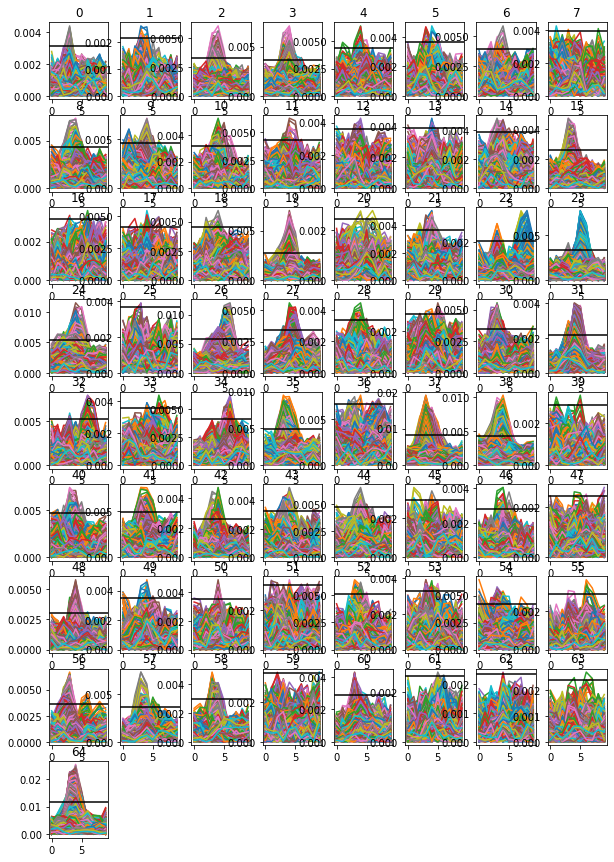

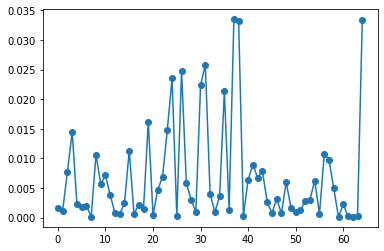

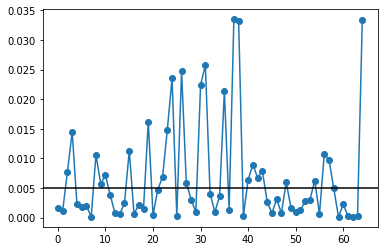

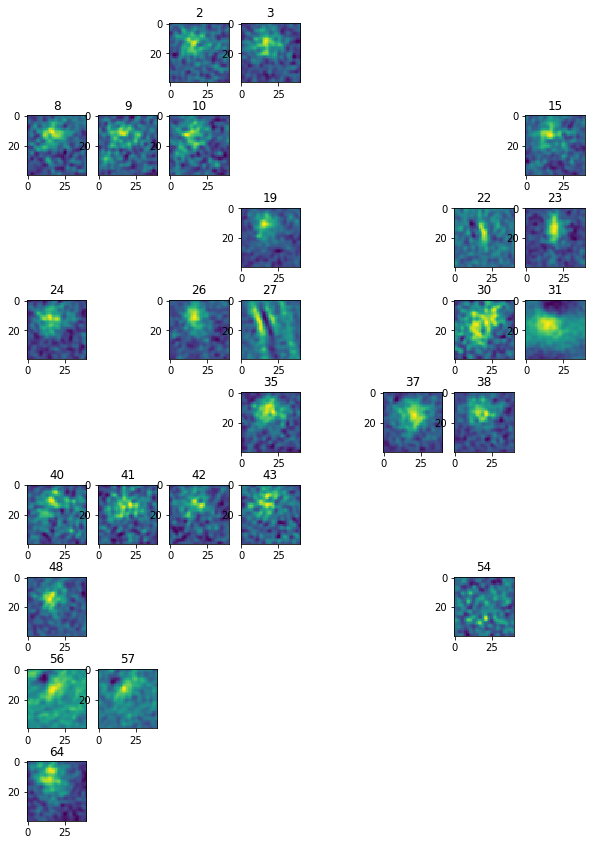

In [15]:
# threshold good STAS
thresh = 0.005
plt.figure()
plt.plot(mu, '-o')
t
plt.axhline(thresh, color='k')

cids = np.where(mu > thresh)[0]
plt.figure(figsize=(10,15))
for cc in cids:#range(NC):
    plt.subplot(sx,sy,cc+1)
    bestlag = np.argmax(np.max(abs(stas[:,:,cc]),axis=0))
    plt.imshow(np.reshape(stas[:,bestlag,cc], (NX,NY)))
    plt.title(cc)

In [16]:
# index into "good" units
Rvalid = Rvalid[:,cids]
NC = Rvalid.shape[1]
stas = stas[:,:,cids]

# Crop stimulus to center around RFs
sumdensity = np.zeros([NX*NY])
for cc in range(NC):
    bestlag = np.argmax(np.max(abs(stas[:,:,cc]),axis=0))
    sumdensity += stas[:,bestlag,cc]**2
plt.imshow(np.reshape(sumdensity, [NX,NY]))

plt.figure()

Cindx = crop_indx( NX, range(0, 30), range(0,30) )
NX2 = np.sqrt(len(Cindx)).astype(int)
print(NX2)
plt.imshow(np.reshape(sumdensity[Cindx],[NX2,NX2]))
plt.title('Cropped')
plt.show()

30


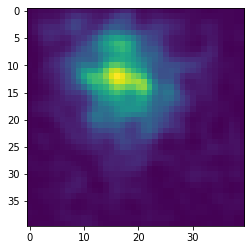

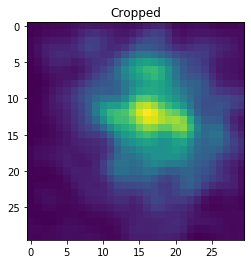

89204 valid samples of 123746 possible


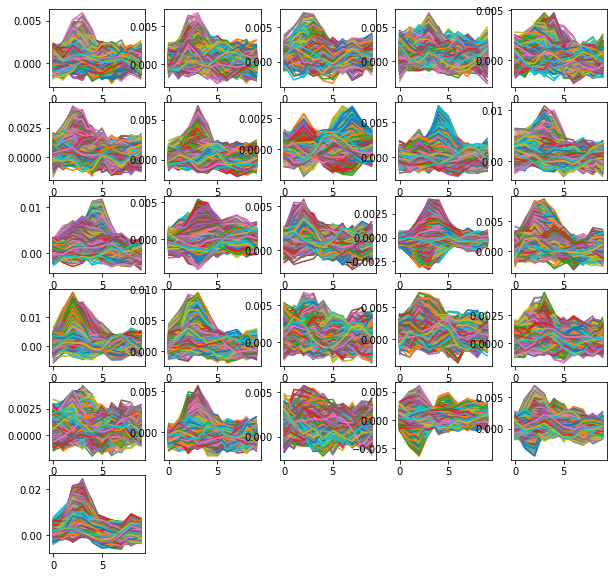

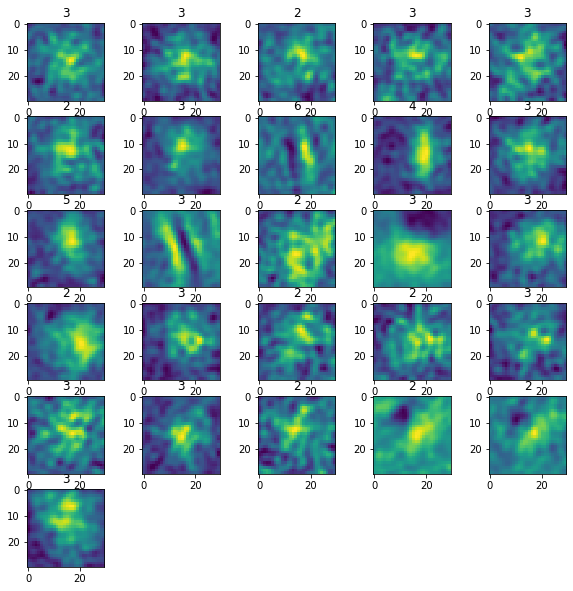

In [19]:
Cindx = crop_indx( NX, range(0, 30), range(0,30) )
NX2 = np.sqrt(len(Cindx)).astype(int)

# make new cropped stimulus
num_lags = 10
Xstim, rinds = create_time_embedding_valid(Stim[:,Cindx], [num_lags, NX2, NX2], valdata)

# index into Robs
Rvalid = deepcopy(Robs[rinds,:])
Rvalid = Rvalid[:,cids]
Rvalid = NDNutils.shift_mat_zpad(Rvalid,-1,dim=0)

NC = Rvalid.shape[1] # new number of units
NT = Rvalid.shape[0]
print('%d valid samples of %d possible' %(NT, Stim.shape[0]))
print('%d good units' %NC)

# recompute STAs to make sure they look good
stas = Xstim.T@(Rvalid - np.average(Rvalid, axis=0))
stas = np.reshape(stas, [NX2*NX2,num_lags, NC])/Rvalid.shape[0]

NT = Xstim.shape[0]
Ui, Xi = NDNutils.generate_xv_folds(NT)


plt.figure(figsize=(10,10))
sx,sy = U.get_subplot_dims(NC)
for cc in range(NC):
    plt.subplot(sx,sy,cc+1)
    plt.plot(np.transpose(stas[:,:,cc]))
    
plt.figure(figsize=(10,10))
sx,sy = U.get_subplot_dims(NC)
for cc in range(NC):
    plt.subplot(sx,sy,cc+1)
    bestlag = np.argmax(np.max(abs(stas[:,:,cc]),axis=0))
    plt.imshow(np.reshape(stas[:,bestlag,cc], (NX2,NX2)))
    plt.title(bestlag)

W0527 11:00:13.318769 140198265808704 deprecation_wrapper.py:119] From /home/jcbyts/Repos/NDN3/NDN.py:270: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0527 11:00:13.320127 140198265808704 deprecation_wrapper.py:119] From /home/jcbyts/Repos/NDN3/NDN.py:278: The name tf.set_random_seed is deprecated. Please use tf.compat.v1.set_random_seed instead.

W0527 11:00:13.321018 140198265808704 deprecation_wrapper.py:119] From /home/jcbyts/Repos/NDN3/NDN.py:281: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W0527 11:00:13.321887 140198265808704 deprecation_wrapper.py:119] From /home/jcbyts/Repos/NDN3/NDN.py:1108: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0527 11:00:13.330679 140198265808704 deprecation_wrapper.py:119] From /home/jcbyts/Repos/NDN3/layer.py:236: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead

Input dimensions: [1, 30, 30, 10]
0: normal (relu):  	[E18/I18] N
1: normal (relu):  	[E12/I12] N+
0: normal (softplus):  	[E26/I0] N


W0527 11:00:20.663704 140198265808704 deprecation_wrapper.py:119] From /home/jcbyts/Repos/NDN3/NDN.py:460: The name tf.summary.scalar is deprecated. Please use tf.compat.v1.summary.scalar instead.

W0527 11:00:20.667755 140198265808704 deprecation_wrapper.py:119] From /home/jcbyts/Repos/NDN3/NDN.py:1252: The name tf.train.AdamOptimizer is deprecated. Please use tf.compat.v1.train.AdamOptimizer instead.

W0527 11:00:20.755846 140198265808704 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0527 11:00:22.749693 140198265808704 deprecation_wrapper.py:119] From /home/jcbyts/Repos/NDN3/NDN.py:359: The name tf.train.Saver is deprecated. Please use tf.compat.v1.train.Saver instead.

W0527 11:00:22.765026 1401982658

Epoch 0000:  avg train cost =     4.9447,  avg test cost =     5.2032,  reg penalty =     0.8307
Epoch 0029:  avg train cost =     3.4668,  avg test cost =     4.3576,  reg penalty =     0.2331
Epoch 0059:  avg train cost =     3.3570,  avg test cost =     4.3677,  reg penalty =     0.2300
Epoch 0089:  avg train cost =     3.3177,  avg test cost =     4.3992,  reg penalty =     0.2301

*** early stop criteria met...stopping train now...
     ---> number of epochs used: 117,  end cost: 120.716073
     ---> best epoch: 39,  best cost: 118.931834

Epoch 0000:  avg train cost =     3.5552,  avg test cost =     4.3072,  reg penalty =     2.6234
Epoch 0029:  avg train cost =     3.6338,  avg test cost =     4.0641,  reg penalty =     0.4286
Epoch 0059:  avg train cost =     3.6384,  avg test cost =     4.0467,  reg penalty =     0.3830
Epoch 0089:  avg train cost =     3.6359,  avg test cost =     4.0418,  reg penalty =     0.3733
Epoch 0119:  avg train cost =     3.6346,  avg test cost =   

(array([ 1.,  2., 13.,  5.,  2.,  1.,  0.,  1.,  0.,  1.]),
 array([-0.23497943, -0.13817507, -0.0413707 ,  0.05543366,  0.15223802,
         0.24904238,  0.34584675,  0.44265111,  0.53945547,  0.63625983,
         0.7330642 ]),
 <a list of 10 Patch objects>)

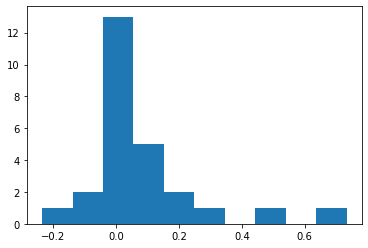

In [20]:
## SCAFFOLD

# Best regularization arrived at
Greg0 = 1e-1
Mreg0 = 1e-6
L1reg0 = 1e-5
XTreg = .05

L1reg = 0.005 # 0.01 optimal but RFs too sparse
MIreg = 0.1
MSCreg = 10.0
Greg = 0.1
Mreg = 1e-4

num_subs = 36
num_hid = 24
num_tkern = None

if not num_tkern is None:
    ndn_par = NDNutils.ffnetwork_params( 
        input_dims=[1,NX2,NX2, num_lags],
        layer_sizes=[num_tkern, num_subs, num_hid], 
        layer_types=['conv', 'normal','normal'], ei_layers=[None,num_subs//2, num_hid//2],
        conv_filter_widths=[1],
        normalization=[1, 1,1], act_funcs=['lin', 'relu', 'relu'], verbose=True,
        reg_list={'d2t':[1e-3],'d2x':[None, XTreg], 'l1':[L1reg0, L1reg0], 'glocal':[Greg0, Greg0]})
else:
    ndn_par = NDNutils.ffnetwork_params( 
        input_dims=[1,NX2,NX2, num_lags],
        layer_sizes=[num_subs, num_hid], 
        layer_types=['normal','normal'], ei_layers=[num_subs//2, num_hid//2],
        normalization=[1, 1], act_funcs=['relu', 'relu'], verbose=True,
        reg_list={'d2xt':[XTreg], 'l1':[L1reg0, L1reg0], 'glocal':[Greg0]})


side_par = NDNutils.ffnetwork_params( 
    network_type='side', xstim_n=None, ffnet_n=0, layer_sizes=[NC], 
    layer_types=['normal'], normalization=[-1], act_funcs=['softplus'], verbose=True,
    reg_list={'max':[Mreg0]})

side_par['pos_constraints']=True

side2 = NDN.NDN( [ndn_par, side_par], ffnet_out=1, noise_dist='poisson' )

_ = side2.train(input_data=Xstim, output_data=Rvalid, train_indxs=Ui, test_indxs=Xi, silent=False, 
                   learning_alg='adam', opt_params=adam_params)

side2.set_regularization('glocal', Greg, layer_target=0)
side2.set_regularization('l1', L1reg, layer_target=0)
side2.set_regularization('max', MIreg, ffnet_target=0, layer_target=1)
side2.set_regularization('max', MSCreg, ffnet_target=1, layer_target=0)

side2b = side2.copy_model()

_ = side2b.train(input_data=Xstim, output_data=Rvalid, train_indxs=Ui, test_indxs=Xi, silent=False, 
                   learning_alg='adam', opt_params=adam_params)

LLs2n = side2b.eval_models(input_data=Xstim, output_data=Rvalid, data_indxs=Xi, nulladjusted=True)
print(np.mean(LLs2n))
plt.hist(LLs2n)

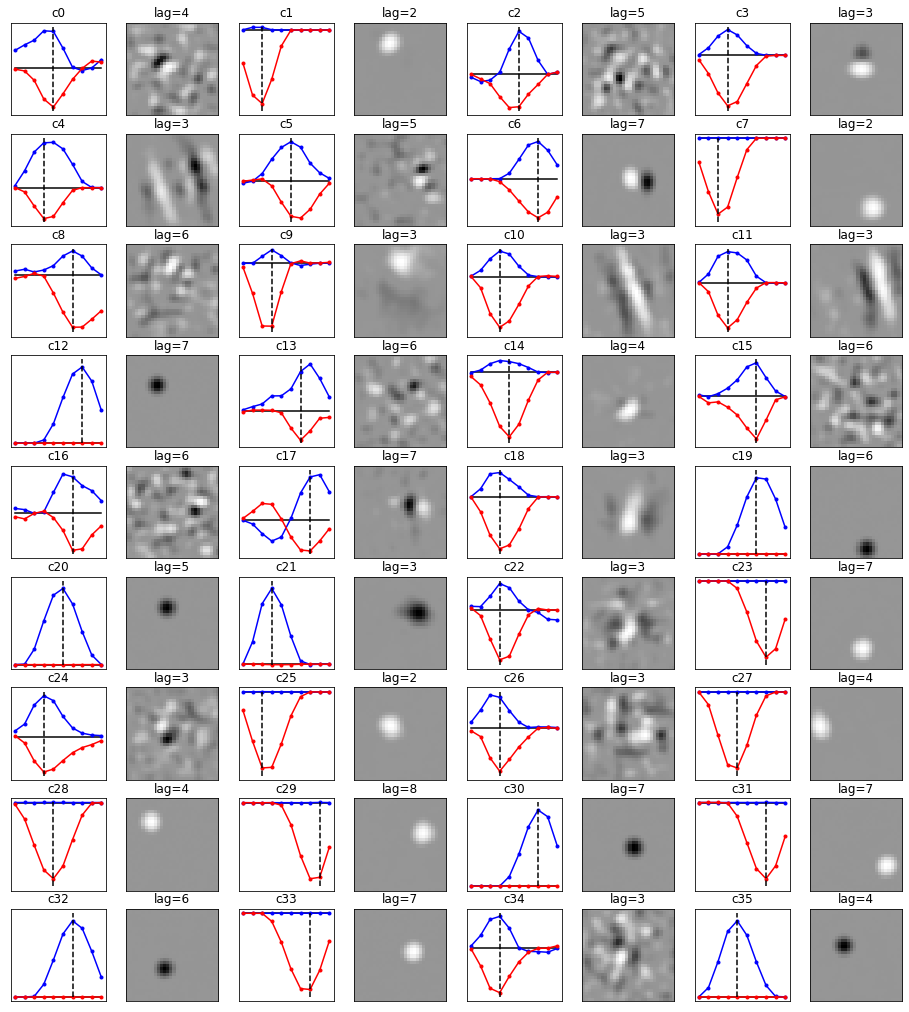

In [21]:
# import importlib
# importlib.reload(DU)
DU.plot_3dfilters(side2b)
# (not hasattr(side2b.networks[0].layers[0], 'filter_basis')) or (side2b.networks[0].layers[0].filter_basis is None)

In [36]:
# prepare for eye-tracking

# recreate full Xstim
Xstim = NDNutils.create_time_embedding(Stim, [num_lags, NX, NY], tent_spacing=1)

# base_mod = NDN.NDN.load_model('/home/dbutts/Marmo/pkls/d1231csn0.pkl')
base_mod = side2b.copy_model()
netlist_old = deepcopy(base_mod.network_list)[0]

In [83]:
# # Scaffold model -- only the second network is non-convolutional
scaff_par = deepcopy(base_mod.network_list[0])
scaff_par['input_dims'] = [1, NX, NY] + [scaff_par['input_dims'][-1]]
scaff_par['layer_types']=['conv', 'conv']
scaff_par['conv_filter_widths'] = [NX2, 1] # base_mod 
num_space = np.prod(netlist_old['input_dims'][1:3])

side_par = deepcopy(base_mod.network_list[1])
side_par['layer_types'] = ['conv']
side_par['conv_filter_widths'] = [1]
#side_par['layer_sizes'][-1] = NC*NX*NX

cell_shift_mod = NDN.NDN( [scaff_par, side_par], ffnet_out=1, noise_dist='poisson' )
# copy first network verbatim (only thing diff is output is a convolution)
cell_shift_mod.networks[0].layers[0].weights = deepcopy(base_mod.networks[0].layers[0].weights)
cell_shift_mod.networks[0].layers[0].biases = deepcopy(base_mod.networks[0].layers[0].biases)
cell_shift_mod.networks[0].layers[1].weights = deepcopy(base_mod.networks[0].layers[1].weights)
cell_shift_mod.networks[0].layers[1].biases = deepcopy(base_mod.networks[0].layers[1].biases)
cell_shift_mod.networks[1].layers[0].weights = deepcopy(base_mod.networks[1].layers[0].weights)
cell_shift_mod.networks[1].layers[0].biases = deepcopy(base_mod.networks[1].layers[0].biases)

-6 -6 -3.843348460314377


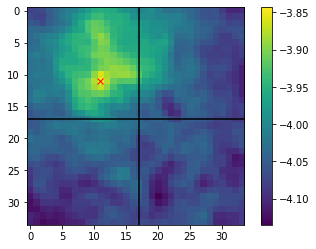

In [85]:

    
# Check likelihood map for models fit to all data (this should hopefully be centered at 0) -- ORIGINAL (XstimL)
x0 = 100.0
y0 = 20.0
Erad = 30.0# in pixels
# eyeX = eyeAtFrame[:,0]-640
# eyeY = eyeAtFrame[:,1]-380

rs = np.hypot(eyeX-x0, eyeY-y0)

valE = np.where(rs < Erad)[0]

valtot = np.intersect1d(valdata, valE)

Rvalid = deepcopy(Robs[:,cids])
mod2 = base_mod.copy_model()
mod2.set_poisson_norm(Rvalid[valtot,:])

crop_edge=3
num_space = np.prod(cell_shift_mod.input_sizes[0][:-1])
Rcc = conv_expand( Rvalid[valtot,:], num_space )
preds = cell_shift_mod.generate_prediction(input_data=[Xstim[valtot,:]])

Nspks = np.maximum(np.sum(Rcc,axis=0), 1)

LLs = poiss_log_like(preds, Rcc)
# LLs = np.divide( np.sum(np.add(np.multiply(Rcc, np.log(np.maximum(preds,1e-12))), -preds), axis=0), Nspks)

LLsp = np.mean( np.reshape(LLs,[NX,NX,NC]), axis=2)
tmp = LLsp[crop_edge:-crop_edge,:]
LLcrop = tmp[:,crop_edge:-crop_edge]

plt.imshow(LLcrop)
plt.colorbar()

min1 = np.argmax(np.max(LLcrop,axis=0))
min2 = np.argmax(np.max(LLcrop,axis=1))
print(min1-NX//2+crop_edge,min2-NX//2+crop_edge, np.max(LLcrop))
plt.imshow(LLcrop)
plt.plot([(NX//2)-crop_edge,(NX//2)-crop_edge],[-0.5,(NX-0.5)-2*crop_edge],'k')
plt.plot([-0.5,(NX-0.5)-2*crop_edge],[NX//2-crop_edge,(NX//2)-crop_edge],'k')
plt.plot(min1,min2,'rx')

plt.show()

In [81]:
# num_space = np.prod(cell_shift_mod.input_sizes[:2])
# num_space
Xstim.shape[1]*26

416000

In [89]:
# Rcc = conv_expand( Rvalid, num_space )
# preds = cell_shift_mod.generate_prediction(input_data=[Xstim])

MemoryError: Unable to allocate 19.2 GiB for an array with shape (123746, 41600) and data type float32

In [67]:
locs = list(range(-240,260,20))
Npos = len(locs)
print(Npos, locs)

25 [-240, -220, -200, -180, -160, -140, -120, -100, -80, -60, -40, -20, 0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240]


In [86]:
# Calculate LL-surface at each position
Erad = ppd*0.75 # in pixels
crop_edge = 3

LLspace1 = np.zeros([Npos,Npos,NX-2*crop_edge,NY-2*crop_edge])
centers1 = np.zeros([Npos,Npos,2])

for xx in range(Npos):
    for yy in range(Npos):

        # get index for when the eye position was withing the boundaries
        rs = np.hypot(eyeX-locs[xx], eyeY-locs[yy])
        valE = np.where(rs < Erad)[0]
        valtot = np.intersect1d(valdata, valE)
        
        if len(valtot) > 10: # at least 100 samples to evaluate a likelihood
            Rcc = conv_expand( Rvalid[valtot,:], num_space )
#             cell_shift_mod.set_poisson_norm(Rcc)

            preds = cell_shift_mod.generate_prediction(input_data=[Xstim[valtot,:]])
    
            LLcc = np.reshape(poiss_log_like(preds, Rcc), [NX,NX,NC])
#             LLcc = np.reshape(
#                 cell_shift_mod.eval_models(
#                     input_data=[Xstim[valtot,:]], 
#                     output_data=Rcc, nulladjusted=False),
#                 [NX,NX,NC])
            LLpos = np.mean(LLcc,axis=2)
            if crop_edge == 0:
                LLspace1[xx,yy,:,:] = deepcopy(LLpos)
            else:
                LLspace1[xx,yy,:,:] = deepcopy(LLpos)[crop_edge:-crop_edge,:][:,crop_edge:-crop_edge]
                
            min1 = np.argmin(np.min(LLspace1[xx,yy,:,:],axis=0))
            min2 = np.argmin(np.min(LLspace1[xx,yy,:,:],axis=1))
            centers1[xx,yy,:] = [min1-NX//2+crop_edge, min2-NX//2+crop_edge]
            print("%3.0f %3.0f (%d): \t(%2d, %2d)"%(locs[xx], locs[yy], 
                                                    len(valtot), min1-NX//2+crop_edge,min2-NX//2+crop_edge))
#             plt.imshow(LLspace1[xx,yy,:,:])
#             plt.plot([(NX//2)-crop_edge,(NX//2)-crop_edge],[-0.5,(NX-0.5)-2*crop_edge],'k')
#             plt.plot([-0.5,(NX-0.5)-2*crop_edge],[NX//2-crop_edge,(NX//2)-crop_edge],'k')
#             plt.plot(min1,min2,'rx')
#             plt.colorbar()
#             plt.show()

-240 -200 (24): 	(-10, -6)
-240 -180 (24): 	(-10, -6)
-240 -140 (55): 	( 1, -14)
-240 -120 (111): 	(13, -8)
-240 -100 (190): 	( 1, -12)
-240 -80 (108): 	(-9, -10)
-240 -60 (191): 	(12, -17)
-240 -40 (421): 	(11, 12)
-240 -20 (588): 	( 3, 13)
-240   0 (283): 	( 2,  9)
-240  20 (219): 	( 7, -10)
-240  40 (200): 	(11, 12)
-240  60 (323): 	( 8, 10)
-240  80 (393): 	(13, -10)
-240 100 (329): 	(12, -6)
-240 120 (213): 	( 1, -3)
-240 140 (124): 	(14,  5)
-240 160 (87): 	( 2, -4)
-240 180 (52): 	(14, 11)
-240 200 (66): 	(-11, 13)
-240 220 (123): 	(-14, 11)
-240 240 (179): 	(15, -5)
-220 -240 (28): 	(-5, -3)
-220 -220 (25): 	(-3, -3)
-220 -200 (47): 	(-10, -6)
-220 -180 (116): 	(-10, -6)
-220 -160 (96): 	(-10, -14)
-220 -140 (186): 	(-15, -11)
-220 -120 (171): 	(-14, -10)
-220 -100 (148): 	(13, -8)
-220 -80 (123): 	( 9, -2)
-220 -60 (143): 	(-10, 16)
-220 -40 (459): 	(12, -17)
-220 -20 (562): 	(10, 14)
-220   0 (489): 	(10, 14)
-220  20 (498): 	(-7,  8)
-220  40 (593): 	( 0, 15)
-220  60 (496):

  0 -60 (1631): 	(-17, 14)
  0 -40 (1709): 	(14, -11)
  0 -20 (1954): 	(11, -4)
  0   0 (1991): 	( 2, 14)
  0  20 (2140): 	( 2, 14)
  0  40 (2294): 	( 1,  8)
  0  60 (2119): 	( 9, 15)
  0  80 (1637): 	( 9,  9)
  0 100 (1657): 	(10, 13)
  0 120 (1856): 	(-1, 11)
  0 140 (1919): 	(-17, 14)
  0 160 (1286): 	(-2,  3)
  0 180 (677): 	( 2,  1)
  0 200 (356): 	( 2,  1)
  0 220 (336): 	(-7,  7)
  0 240 (387): 	( 7,  0)
 20 -240 (234): 	(-1, 13)
 20 -220 (267): 	(10, 16)
 20 -200 (491): 	(-5, 14)
 20 -180 (1064): 	(-12, 11)
 20 -160 (1570): 	(-17,  7)
 20 -140 (1659): 	(-15,  8)
 20 -120 (1069): 	(-9, 14)
 20 -100 (1139): 	(10,  1)
 20 -80 (1422): 	( 6,  7)
 20 -60 (1351): 	( 8, -10)
 20 -40 (1414): 	( 9, -10)
 20 -20 (1550): 	(11, -4)
 20   0 (1595): 	(12, 12)
 20  20 (2041): 	(14, 13)
 20  40 (2059): 	(15, 12)
 20  60 (1617): 	( 4,  3)
 20  80 (1373): 	( 9, 10)
 20 100 (1300): 	( 8, 11)
 20 120 (1594): 	(-17, 16)
 20 140 (1709): 	(-17, 16)
 20 160 (1181): 	(10, -3)
 20 180 (666): 	(-9, 10)
 2

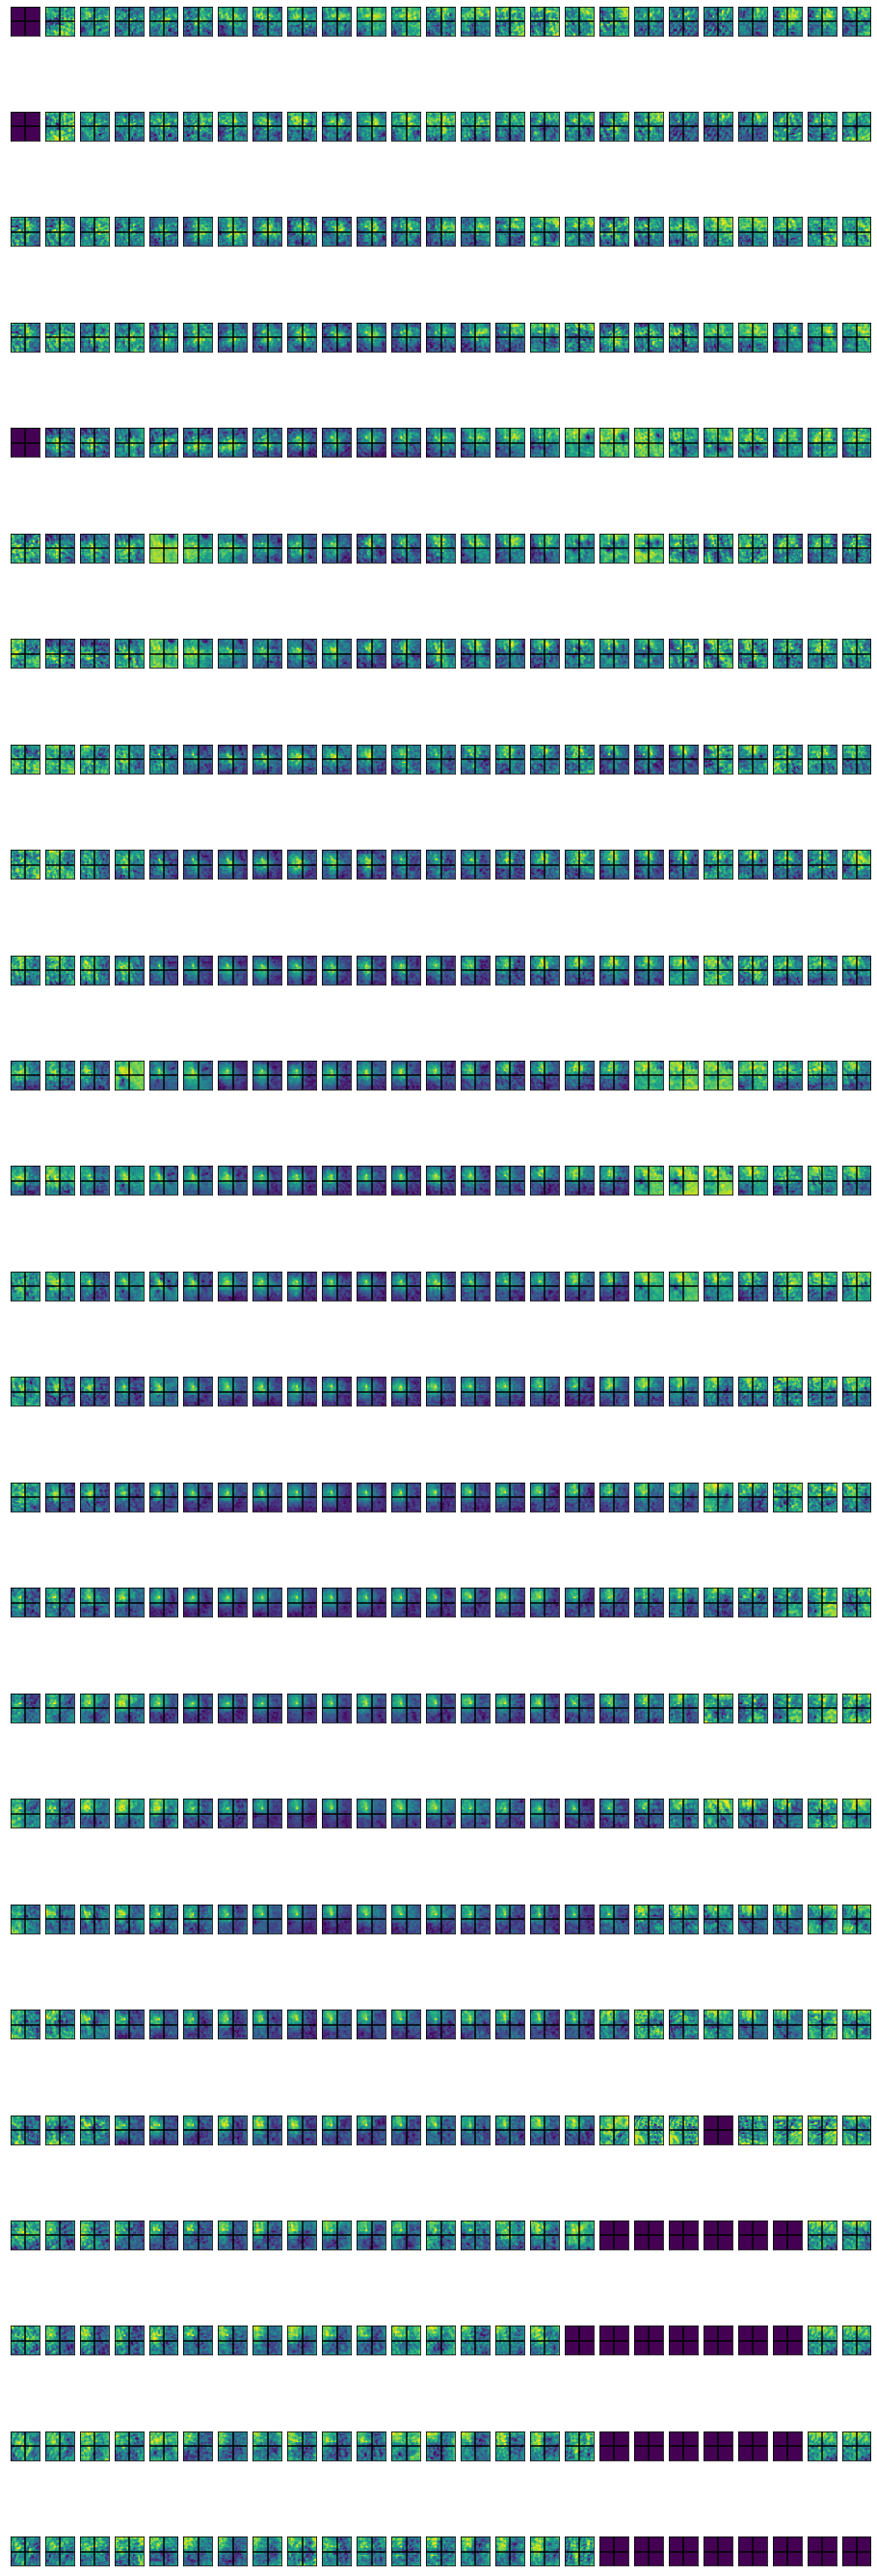

In [87]:
DU.subplot_setup(Npos,Npos)
for xx in range(Npos):
    for yy in range(Npos):
        if LLspace1[xx][yy] is not None:
            ax = plt.subplot(Npos,Npos,yy*Npos+xx+1)
            plt.imshow(LLspace1[xx,yy,:,:])
            plt.plot([(NX//2)-crop_edge,(NX//2)-crop_edge],[-0.5,(NX-0.5)-2*crop_edge],'k')
            plt.plot([-0.5,(NX-0.5)-2*crop_edge],[NX//2-crop_edge,(NX//2)-crop_edge],'k')
            ax.set_xticks([])
            ax.set_yticks([])
            #plt.title("%0.1f, %0.1f"%((xx-13)*20, (yy-13)*20))
plt.show()

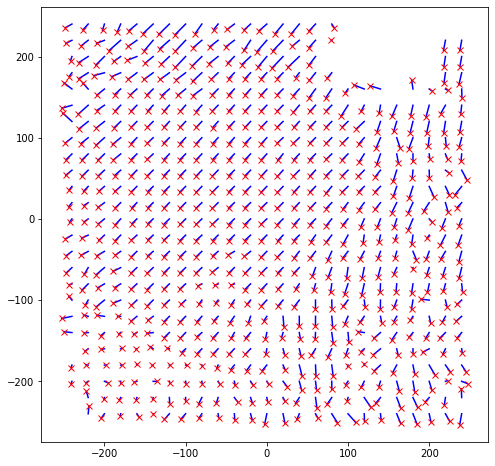

In [147]:
plt.figure(figsize=(8,8))
for xx in range(Npos):
    for yy in range(Npos):
        plt.plot([locs[xx],centers5[xx,yy,0]+locs[xx]], [locs[yy], centers5[xx,yy,1]+locs[yy]],'b')
        plt.plot(centers5[xx,yy,0]+locs[xx], centers5[xx,yy,1]+locs[yy],'rx')
plt.axis('equal')
plt.show()

In [96]:
def LLsmoother(LLspace, smooth=3):
    h = np.ones((smooth,smooth))/smooth**2 # 2D boxcar kernel
    sLLspace = convolve2d(LLspace, h, 'same')
    return sLLspace
    


In [97]:
LLspace3 = deepcopy(LLspace1)
wsp = 0.25 # how much to weight neighboring LL surfaces
for xx in range(Npos):
    for yy in range(Npos):
        Lsm = LLsmoother(LLspace1[xx,yy,:,:])
        if xx > 0:
            LLspace3[xx,yy,:,:] += wsp*LLsmoother(LLspace1[xx-1,yy,:,:])
        if yy > 0:
            LLspace3[xx,yy,:,:] += wsp*LLsmoother(LLspace1[xx,yy-1,:,:])
        if xx < Npos-1:
            LLspace3[xx,yy,:,:] += wsp*LLsmoother(LLspace1[xx+1,yy,:,:])
        if yy < Npos-1:
            LLspace3[xx,yy,:,:] += wsp*LLsmoother(LLspace1[xx,yy+1,:,:])
            

In [130]:
centers5 = deepcopy(centers1)
for xx in range(Npos):
    for yy in range(Npos):
            I = deepcopy(LLspace1[xx,yy,1:-1,1:-1])
            I = (I - np.min(I)) / (np.max(I)-np.min(I))
            
#             min1 = np.argmax(np.max(LLspace3[xx,yy,1:-1,1:-1],axis=0))
#             min2 = np.argmax(np.max(LLspace3[xx,yy,1:-1,1:-1],axis=1))
            min1,min2 = radialcenter(I**10)
            centers5[xx,yy,:] = [min1-NX//2+crop_edge, min2-NX//2+crop_edge]
    

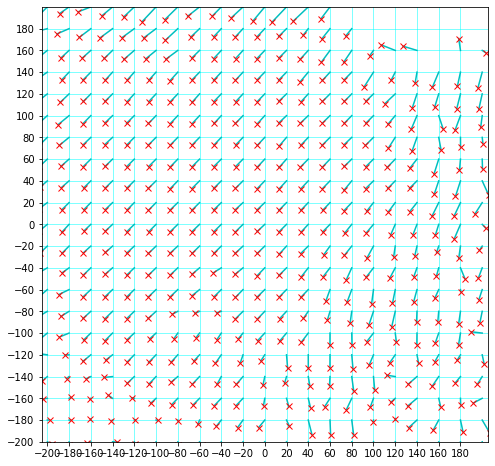

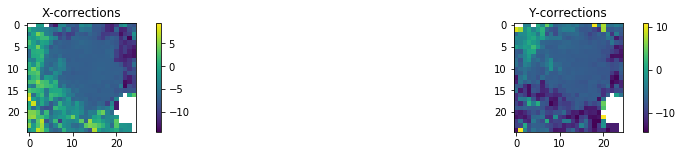

In [131]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
for xx in range(Npos):
    for yy in range(Npos):
        plt.plot([locs[xx],centers5[xx,yy,0]+locs[xx]], [locs[yy], centers5[xx,yy,1]+locs[yy]],'c')
        plt.plot(centers5[xx,yy,0]+locs[xx], centers5[xx,yy,1]+locs[yy],'rx')
plt.axis('equal')

plt.xlim([-200,200])
plt.ylim([-200,200])
ax.set_xticks(np.arange(-200, 200, 20))
ax.set_yticks(np.arange(-200, 200, 20))
ax.grid()
ax.grid(linestyle='-', linewidth='0.5', color='cyan')
plt.show()

DU.subplot_setup(1,2)
plt.subplot(1,2,1)
plt.imshow(centers5[:,:,0])
plt.colorbar()
plt.title('X-corrections')
plt.subplot(1,2,2)
plt.imshow(centers5[:,:,1])
plt.colorbar()
plt.title('Y-corrections')
plt.show()

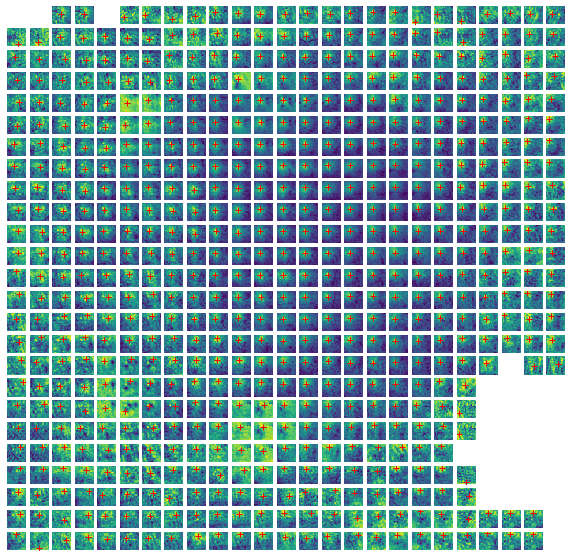

In [138]:
plt.figure(figsize=(10,10))
for xx in range(Npos):
    for yy in range(Npos):
        plt.subplot(Npos,Npos,xx*Npos + yy + 1)

        I = deepcopy(LLspace1[xx,yy,1:-1,1:-1])
        I = (I - np.min(I)) / (np.max(I)-np.min(I))

        plt.imshow(I)
        xc,yc=radialcenter(I**10)
        plt.plot(xc, yc, '+r')
        plt.axis("off")



In [136]:
corrgrid = deepcopy(centers5)
a = np.where(corrgrid > 8.0)
corrgrid[a] = 8.0
b = np.where(corrgrid < -8)
corrgrid[b] = -8

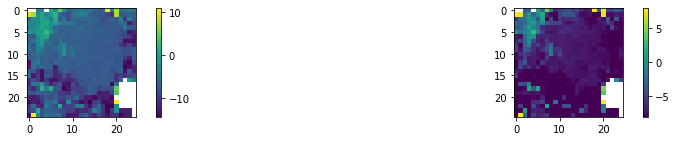

In [137]:
DU.subplot_setup(1,2)
plt.subplot(1,2,1)
plt.imshow(centers5[:,:,1])
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(corrgrid[:,:,1])
plt.colorbar()
plt.show()

In [185]:
corrgrid[np.isnan(corrgrid)] = 0
coords = np.zeros([25*25,4])
nn = 0
for xx in range(Npos):
    for yy in range(Npos):
        coords[nn,:] = [locs[xx], locs[yy], corrgrid[xx,yy,0], corrgrid[xx,yy,1]]
        nn += 1
        

In [ ]:
scx = np.divide(deepcopy(ex)+240, 20)
scy = np.divide(deepcopy(ey)+240, 20)

In [201]:
from scipy.interpolate import LinearNDInterpolator,interp2d

In [204]:
aloc = np.asarray(locs)
# xcorrec = interp2d(aloc, aloc,corrgrid[:,:,0], kind='linear')
# ycorrec = interp2d(aloc, aloc,corrgrid[:,:,1], kind='linear')

# xcorrec = interp2d(coords[:,0], coords[:,1],coords[:,2], kind='linear')
# ycorrec = interp2d(coords[:,0], coords[:,1],coords[:,3], kind='linear')

xcorrec = LinearNDInterpolator(coords[:,0:2], coords[:,2])
ycorrec = LinearNDInterpolator(coords[:,0:2], coords[:,3])

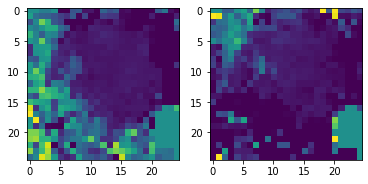

In [205]:
# xcorrec(eyeX, eyeY)
plt.subplot(121)
plt.imshow(np.reshape(xcorrec(coords[:,0], coords[:,1]), (Npos,Npos)))
plt.subplot(122)
plt.imshow(np.reshape(ycorrec(coords[:,0], coords[:,1]), (Npos,Npos)))


In [ ]:
plt.plot(xcorrec(eyeX, eyeY))
plt.xlim((0, 1000))
# xcorrec(eyeX[0:2], eyeY[0:2])

In [221]:
xshift = xcorrec(eyeX, eyeY)
yshift = ycorrec(eyeX, eyeY)

from tqdm import tqdm

In [223]:
StimC = deepcopy(Stim)
NT = StimC.shape[0]

xax = np.arange(0,NX,1) - NX/2
yax = np.arange(0,NY,1) - NY/2

for iFrame in tqdm(range(NT)):
    I = np.reshape(Stim[iFrame,:], (NX, NY))
#     plt.subplot(1,2,1)
#     plt.imshow(I)

    imshifter = interp2d(xax, yax, I)
# plt.subplot(1,2,2)
# plt.imshow(
    StimC[iFrame,:] = imshifter(xax+xshift[iFrame],yax+yshift[iFrame]).flatten()


100%|██████████| 123746/123746 [00:12<00:00, 9538.24it/s]


In [225]:
# clean up some variables
del Xstim

30402 valid samples of 123746 possible


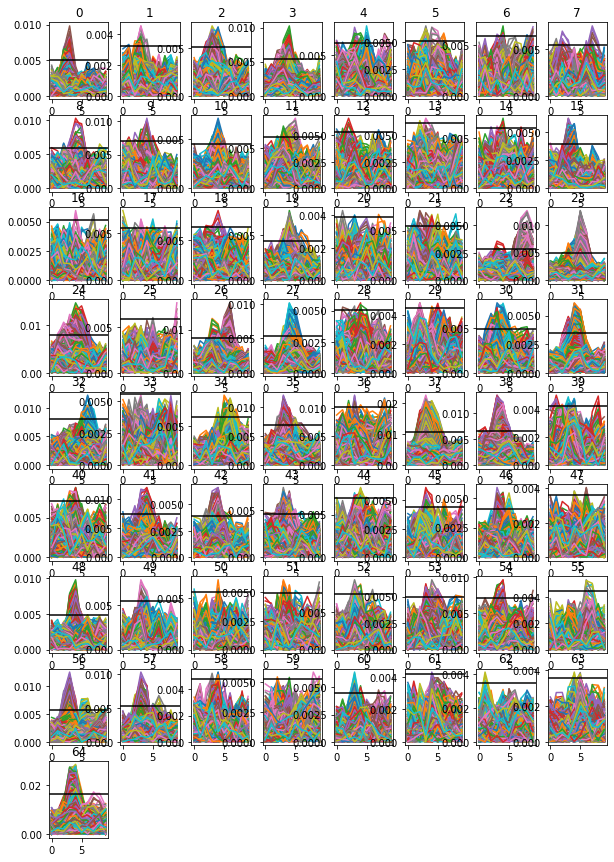

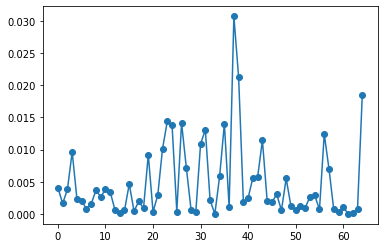

In [242]:
num_lags = 10
NC = Robs.shape[1]
Xstim, rinds = create_time_embedding_valid(StimC, [num_lags, NX, NY], valdata)
Rvalid = deepcopy(Robs[rinds,:])

NT = Rvalid.shape[0]
print('%d valid samples of %d possible' %(NT, Stim.shape[0]))

stas = Xstim.T@(Rvalid - np.average(Rvalid, axis=0))
stas = np.reshape(stas, [NX*NY,num_lags, NC])/Rvalid.shape[0]

# check STAs: is there signal?
plt.figure(figsize=(10,15))
sx,sy = U.get_subplot_dims(NC)

mu = np.zeros(NC)
for cc in range(NC):
    plt.subplot(sx,sy,cc+1)
    plt.plot(np.abs(np.transpose(stas[:,:,cc])))
    t = np.median(abs(stas[:,:,cc]-np.average(stas[:,:,cc])))*6
    mu[cc] = np.average(np.abs(stas[:,:,cc])>t)
    plt.axhline(t, color='k')
    plt.title(cc)

plt.figure()
plt.plot(mu, '-o')
plt.show()
    

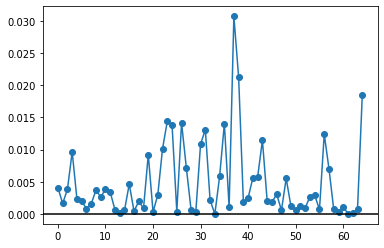

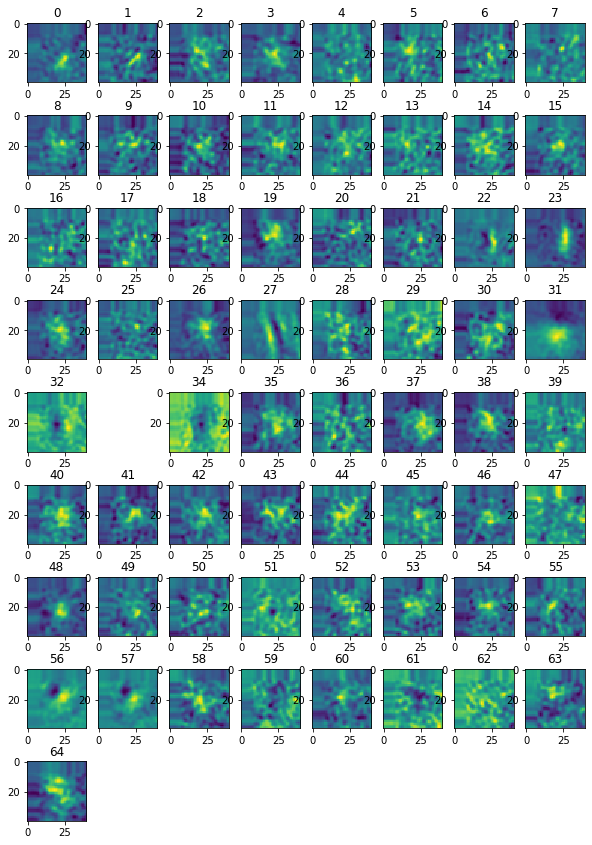

In [244]:
# threshold good STAS
thresh = 0.00
plt.figure()
plt.plot(mu, '-o')

plt.axhline(thresh, color='k')

cids = np.where(mu > thresh)[0]
plt.figure(figsize=(10,15))
for cc in cids:#range(NC):
    plt.subplot(sx,sy,cc+1)
    bestlag = np.argmax(np.max(abs(stas[:,:,cc]),axis=0))
    plt.imshow(np.reshape(stas[:,bestlag,cc], (NX,NY)))
    plt.title(cc)


In [238]:
# garbage collection (amazing!)
import gc
gc.enable()
gc.collect()

In [241]:
# gc.collect()


76161